# Over-collateralization with random sampling, v1

## Set up

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Formulation

### Variables

- $f_\text{IB}$: production rate for IBs, per slot
- $\kappa$: duration of concurrency period, measured in slots
- $B$: maximum number of transactions allowed in an IB
- $M$: maximum number of transactions in the *active* memory pool
- $\beta = B / M$: probability of a transaction being selected for a particular IB

### Assumptions

Note that the *active* portion of the memory pool is the transactions eligible for immediate inclusion in IBs. There may be inactive parts of the memory pool, queues, etc., but they aren't of concern here. The active memory pool will provide backpressure on its upstream feeders.

For simplicity, we assume that a node will note be elected to build more than a single block during the concurrency period. (Presumably, the same node would never put a particular transaction in more than one IB.) Given the number of stakepools and stake distribution on Cardano `mainnet`, this is an accurate assumption. This assumption could be removed from a Delta QSD analysis or a Markov-chain simulations.

### Probabilities

#### Waiting time for a transaction to reach its first IB

The probability of the transaction being one of the $B$ transactions selected from the $M$ transactions in an IB is as follows.

$$
\left. {M - 1 \choose B} \middle/ {M \choose B} \right. = B / M = \beta
$$

IBs are created at the rate $f_\text{IB}$ and the transaction has a probability $\beta$ of being in each. Sortition occurs for each unit of stake, so we have the probability per slot of a transaction being included in at least one IB as $g_\text{TX} = 1 - e^{- \beta \cdot f_\text{IB}}$ and the waiting time as negative binomially distributed.

$$
p_\text{wait}(s) := \mathsf{P}(\text{TX first included in an IB after } s \text{ slots}) = \\
(1 - g_\text{TX})^s \cdot g_\text{TX}
$$

#### Duplicate of a transaction in the same concurrency period

Under the previously stated assumption that the same node does not produce two IBs in the same concurrency period, the transaction-inclusion process follows a binomial distribution in $g_\text{TX}$. The probability the the transaction is not selected at all during the concurrency period is $(1 - g_\text{TX})^\kappa$ and the probability that it is selected exactly once is $\kappa \cdot g_\text{TX} \cdot (1 - g_\text{TX})^{\kappa - 1}$. Thus the probability of at least one duplicate inclusion is as follows.

$$
p_\text{duplicate} := \mathsf{P}(\text{TX included in more than one IB during the concurrency period}) \\
= 1 - ( 1 + (\kappa - 1) \cdot g_\text{TX} ) \cdot (1 - g_\text{TX})^{\kappa - 1}
$$

#### Spatial efficiency

The "spatial efficiency" is the ratio of the number of unique transactions in IBs to the total number of transactions in IBs.

$$
\epsilon_\text{space} = \frac{\kappa \cdot g_\text{TX} \cdot (1 - g_\text{TX})^{\kappa - 1}}{\kappa \cdot g_\text{TX}} = (1 - g_\text{TX})^{\kappa - 1}
$$

#### Conflicting transaction in the same concurrency period

Let $C$ be the number of transactions that in the active memory pool that conflict with a given transaction. Note that those transactions may or may not be mutually conflicting, so the set is not necessarily a clique.

Given that a particular transaction is included during a concurrency period, the probability for conflicting transactions being included in the same concurrency period is binomially distributed with a probability $q_\text{TX} = 1 - (1 - g_\text{TX})^\kappa = 1 - e^{- \kappa \cdot \beta \cdot f_\text{IB}}$ according to the sortition argument.

$$
p_\text{conflicts} := \mathsf{P}(m \text{ conflicting transactions are included in an IB during the concurrency period}) \\
= {C \choose m} \cdot {q_\text{TX}}^m \cdot (1 - q_\text{TX})^{C - m}
$$

The expected number of conflicts is $\mu_\text{conflicts} = C \cdot q_\text{TX} = C \cdot [ 1 - (1 - g_\text{TX})^\kappa ]$ or $\mu_\text{conflicts}\, / \, C = 1 - (1 - g_\text{TX})^\kappa$.

Note that we always have $\mu_\text{conflicts}\, / \, C > p_\text{duplicate}$, which means that conflict is more of a risk than duplication.

#### Overcollateralization

Consider the transaction that has $C$ conflicting transactions in the active memory pool, so $\rho = C \, / \, M$ is the fraction of the memory pool that it conflicts with.

Trivially, the previous result implies that $\rho_\text{conflicts} = \rho \cdot [ 1 - (1 - g_\text{TX})^\kappa ]$ is the expect number of conflicts in IBs during the concurrency period.



## Numerical exploration

### Probability of transaction being included in any IB in a slot

The analytics discussion indicates that $g_\text{TX}$ is the primary variable of interest and that it depends upon $\beta$ and $f_\text{IB}$. Later plots will be simplier if parameterized by $g_\text{TX}$.

In [100]:
gTXtable <- CJ(`beta`=1:99/100, `fIB`=c(0.1, 0.3, 1.0, 3.0, 10.0, 30.0))[, .(
    `beta`,
    `fIB`, 
    `gTX`=(1 - exp(- `beta` * `fIB`))
)]

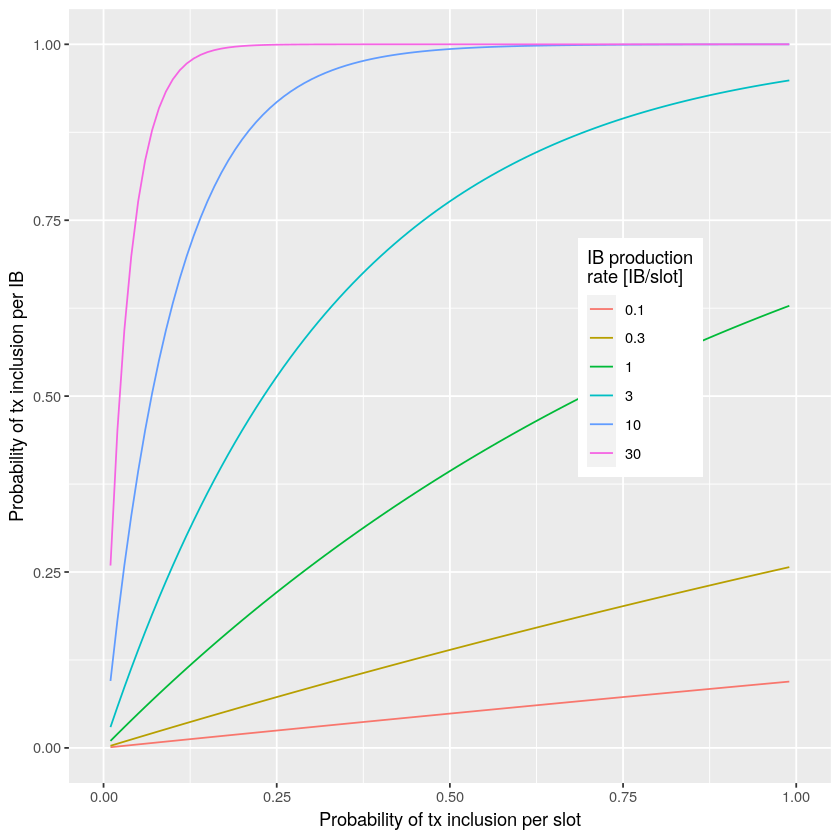

In [123]:
ggplot(gTXtable, aes(x=`beta`, y=`gTX`, color=factor(`fIB`))) +
    geom_line() +
    xlim(0, 1) +
    ylim(0, 1) +
    xlab("Probability of tx inclusion per slot") +
    ylab("Probability of tx inclusion per IB") +
    guides(color=guide_legend(title="IB production\nrate [IB/slot]")) +
    theme(legend.position = c(0.75, 0.55))

### Cumulative probability for waiting time of transaction to be included in an IB

In [126]:
pWait <- function(s, gTX)
    pnbinom(s, 1, gTX)

In [127]:
pWaitTable <- CJ(`s`=1:30, `gTX`=1:9/10)[, .(
    `s`,
    `gTX`,
    `pInclude`=mapply(pInclude, `s`, `gTX`)
)]

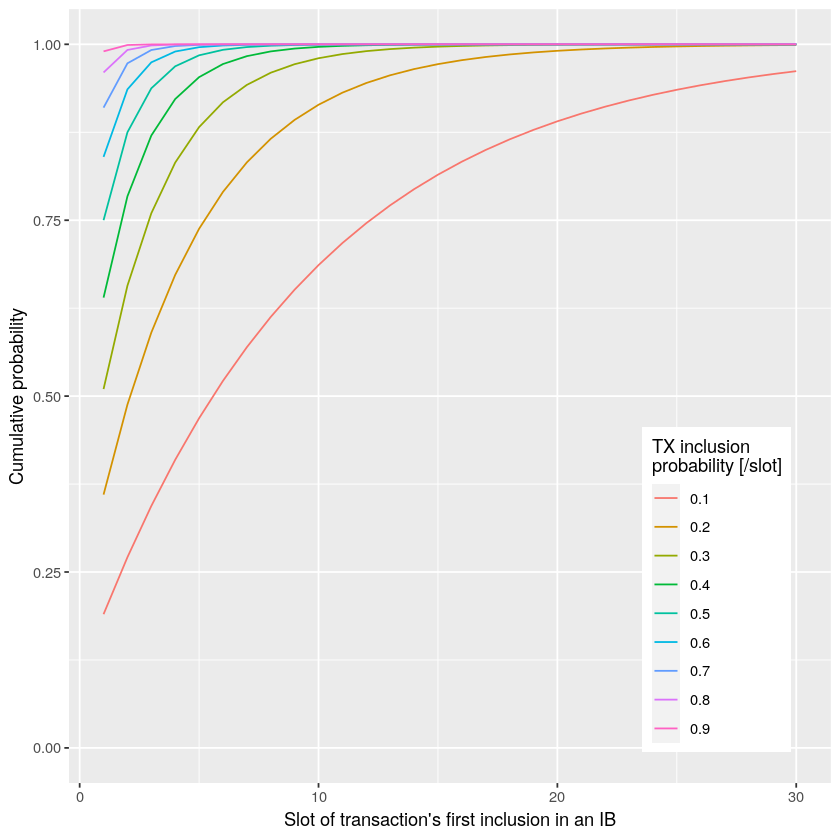

In [128]:
ggplot(pWaitTable, aes(x=`s`, y=`pInclude`, color=factor(`gTX`))) +
  geom_line() +
    ylim(0, 1) +
    xlab("Slot of transaction's first inclusion in an IB") +
    ylab("Cumulative probability") +
    guides(color=guide_legend(title="TX inclusion\nprobability [/slot]")) +
    theme(legend.position = c(0.85, 0.25))

### Probability of transaction duplicate in concurrency period

In [94]:
pDuplicate <- function(kappa, gTX)
    1 - (1 + gTX * (kappa - 1)) * (1 - gTX)^(kappa - 1)

In [95]:
pDuplicateTable <- CJ(`kappa`=1:30, `gTX`=1:9/10)[, .(
    `kappa`,
    `gTX`,
    `pDuplicate`=mapply(pDuplicate, `kappa`, `gTX`)
)]

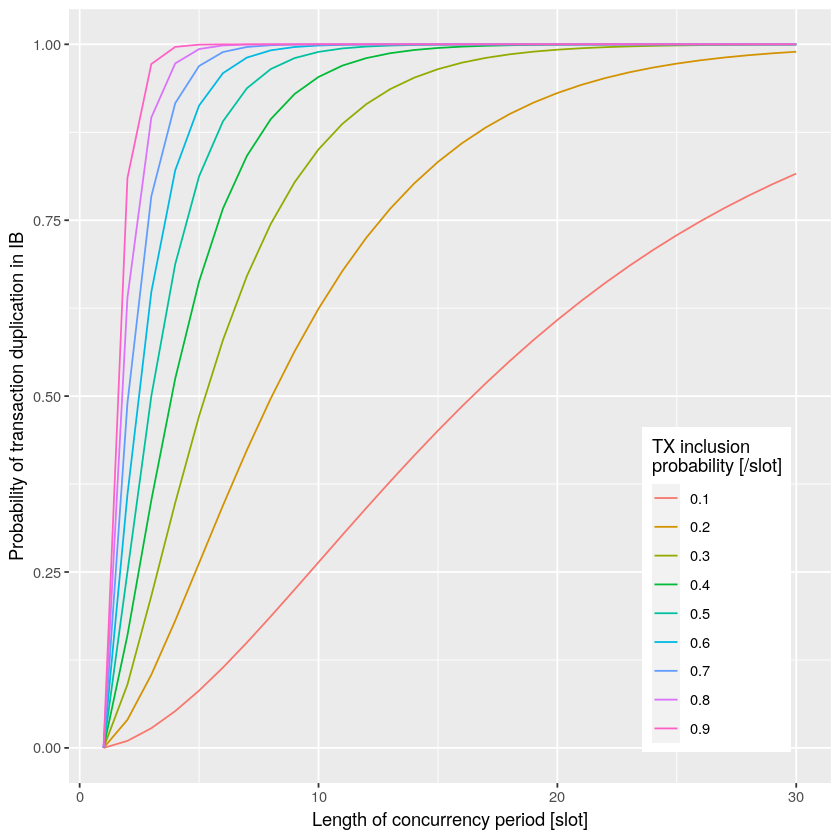

In [125]:
ggplot(pDuplicateTable, aes(x=`kappa`, y=`pDuplicate`, color=factor(`gTX`))) +
  geom_line() +
    ylim(0, 1) +
    xlab("Length of concurrency period [slot]") +
    ylab("Probability of transaction duplication in concurrency period") +
    guides(color=guide_legend(title="TX inclusion\nprobability [/slot]")) +
    theme(legend.position = c(0.85, 0.25))

### Spatial efficiency

In [131]:
eSpace <- function(kappa, gTX)
    (1 - gTX)^kappa

In [132]:
eSpaceTable <- CJ(`kappa`=1:30, `gTX`=1:9/10)[, .(
    `kappa`,
    `gTX`,
    `eSpace`=mapply(pConflict, `kappa`, `gTX`)
)]

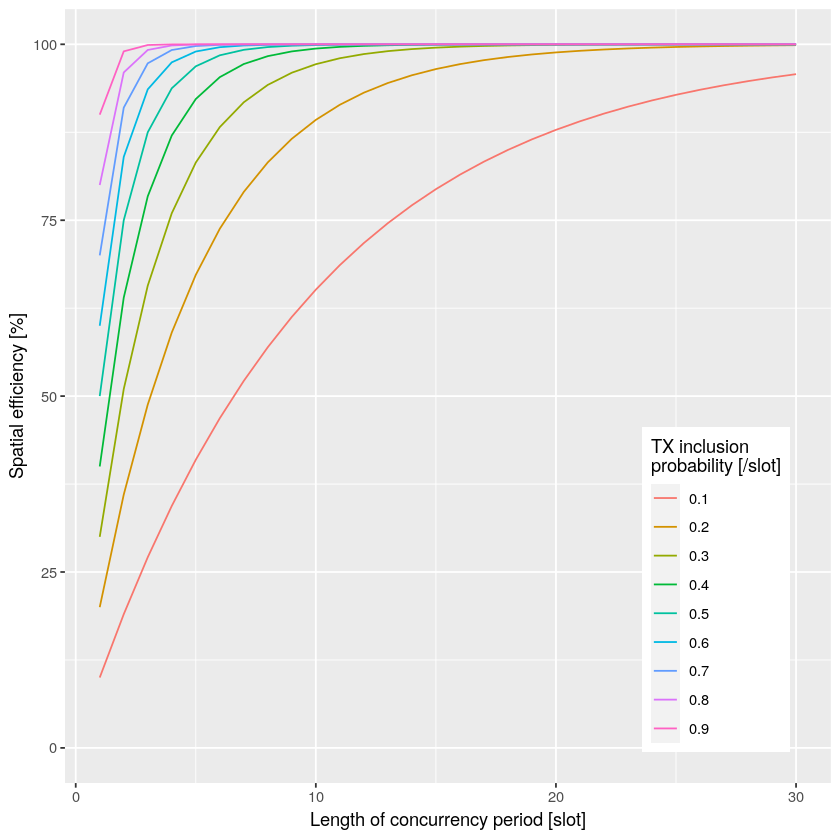

In [137]:
ggplot(eSpaceTable, aes(x=`kappa`, y=100*`eSpace`, color=factor(`gTX`))) +
  geom_line() +
    ylim(0, 100) +
    xlab("Length of concurrency period [slot]") +
    ylab("Spatial efficiency [%]") +
    guides(color=guide_legend(title="TX inclusion\nprobability [/slot]")) +
    theme(legend.position = c(0.85, 0.25))

### Probability of conflicting transaction in the same concurrency period

In [110]:
pConflict <- function(kappa, gTX)
    1 - (1 - gTX)^kappa

In [111]:
pConflictTable <- CJ(`kappa`=1:30, `gTX`=1:9/10)[, .(
    `kappa`,
    `gTX`,
    `pConflict`=mapply(pConflict, `kappa`, `gTX`)
)]

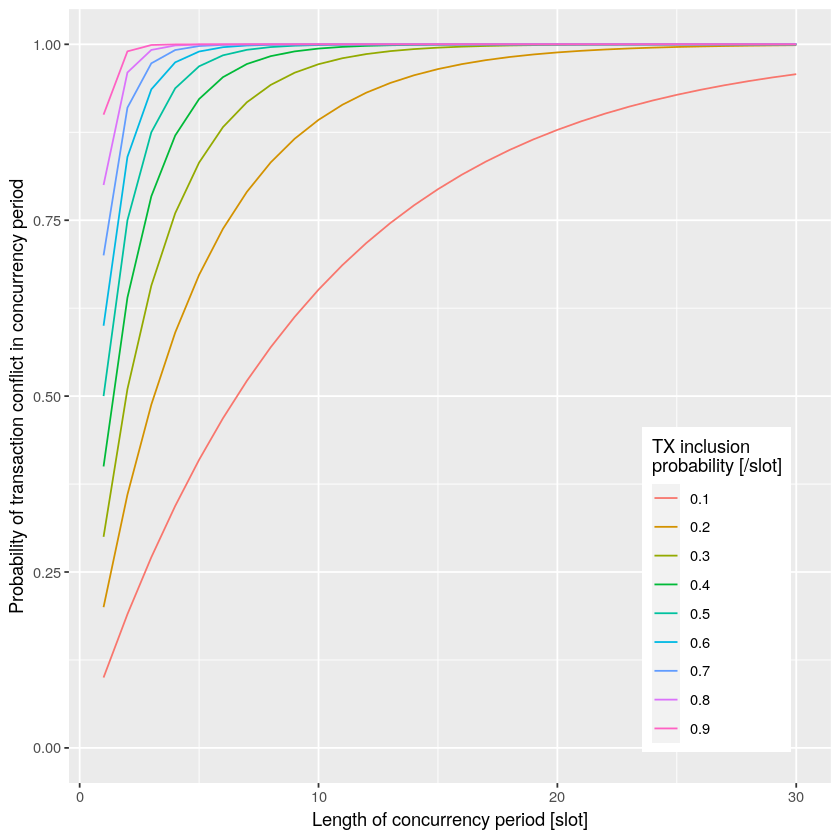

In [119]:
ggplot(pConflictTable, aes(x=`kappa`, y=`pConflict`, color=factor(`gTX`))) +
  geom_line() +
    ylim(0, 1) +
    xlab("Length of concurrency period [slot]") +
    ylab("Probability of transaction conflict in concurrency period") +
    guides(color=guide_legend(title="TX inclusion\nprobability [/slot]")) +
    theme(legend.position = c(0.85, 0.25))

### Tradeoff between duplication and conflict

In [138]:
pDuplicateConflictTable <- CJ(`kappa`=1:30, `gTX`=1:9/10)[, .(
    `kappa`,
    `gTX`,
    `pDuplicate`=mapply(pDuplicate, `kappa`, `gTX`),
    `pConflict`=mapply(pConflict, `kappa`, `gTX`)
)]

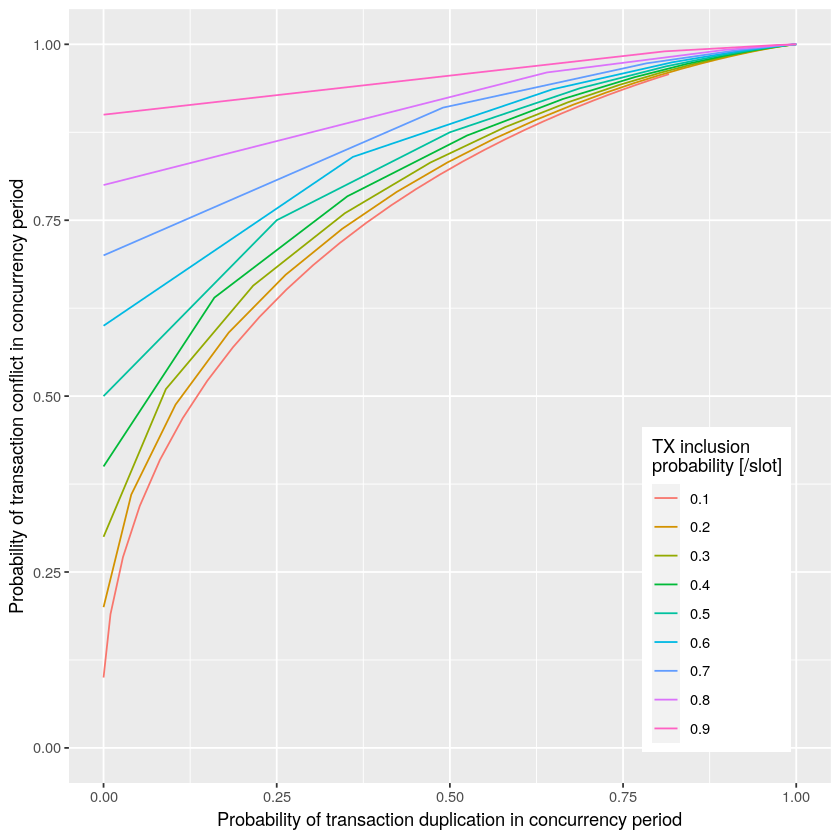

In [141]:
ggplot(pDuplicateConflictTable, aes(x=`pDuplicate`, y=`pConflict`, color=factor(`gTX`))) +
  geom_line() +
    xlim(0, 1) +
    ylim(0, 1) +
    xlab("Probability of transaction duplication in concurrency period") +
    ylab("Probability of transaction conflict in concurrency period") +
    guides(color=guide_legend(title="TX inclusion\nprobability [/slot]")) +
    theme(legend.position = c(0.85, 0.25))

### Overcollateralization

In [167]:
overcollateralizationTable <- CJ(`beta`=1:9/10, `rho`=1:4*0.2, `gPrimeTX`=1:9/10, `B`=1:4*10)[, .(
    `beta`,
    `rho`,
    `gPrimeTX`,
    `B`,
    `O`=`B`*`rho`/`beta`*(1-`gPrimeTX`)
)]

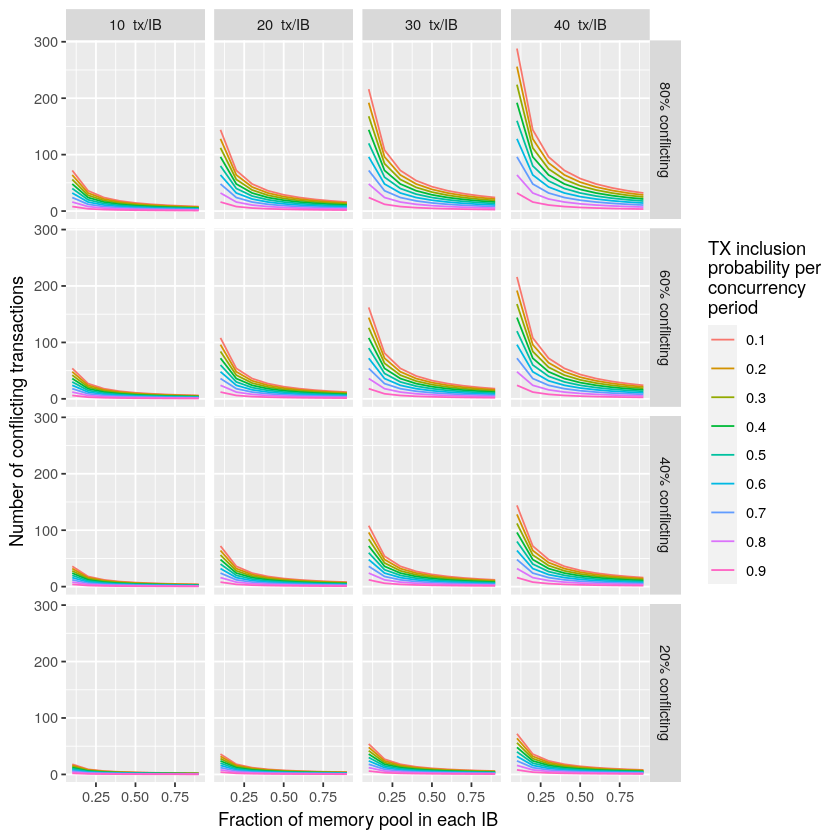

In [172]:
ggplot(overcollateralizationTable[, .(
    `beta`,
    `rho`=factor(paste0(100*`rho`, "% conflicting"), levels=c("80% conflicting", "60% conflicting", "40% conflicting", "20% conflicting")),
    `gPrimeTX`,
    `B`=paste(`B`, " tx/IB"),
    `O`
)], aes(x=`beta`, y=`O`, color=factor(`gPrimeTX`))) +
    geom_line() +
    facet_grid(`rho` ~ `B`) +
    xlab("Fraction of memory pool in each IB") +
    ylab("Number of conflicting transactions") +
    guides(color=guide_legend(title="TX inclusion\nprobability per\nconcurrency\nperiod"))

In [182]:
overcollateralizationTable <- CJ(`fTX`=c(1,3,10,30,100,300,1000), `rho`=1:9*0.1, `tau`=c(30,60,90,120), `kappa`=c(5,10,20))[, .(
    `fTX`,
    `rho`,
    `tau`,
    `kappa`,
    `O`=`fTX`*`rho`*`tau`*exp(-`kappa`/`tau`)
)]

In [ ]:
100 tps * 0.20 * 

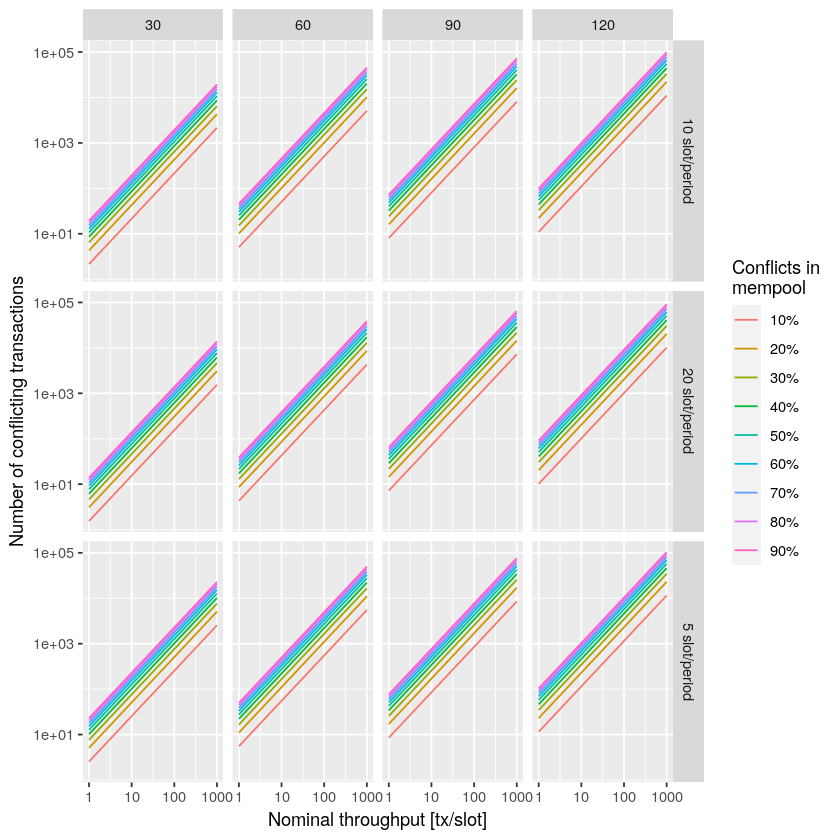

In [185]:
ggplot(overcollateralizationTable[, .(
    `fTX`,
    `rho`=paste0(100*`rho`, "%"),
    `tau`,
    `kappa`=paste(`kappa`, "slot/period"),
    `O`
)], aes(x=`fTX`, y=`O`, color=factor(`rho`))) +
    geom_line() +
    facet_grid(`kappa` ~ `tau`) +
    scale_x_log10() +
    scale_y_log10() +
    xlab("Nominal throughput [tx/slot]") +
    ylab("Number of conflicting transactions") +
    guides(color=guide_legend(title="Conflicts in\nmempool"))